In [16]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import random
import os
import seaborn as sn
random.seed(1234)

In [5]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__169_79.4_(+29.9519875292,+72.5105724296)_PK_Punjab_nan_Vihari.jpg  
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__170_79.7_(+29.9519875292,+72.5306946920)_PK_Punjab_nan_Vihari.jpg  
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__171_79.3_(+29.9519875292,+72.6111837414)_PK_Punjab_nan_Burewala.jpg  
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__172_79.5_(+29.9318652668,+72.4904501673)_PK_Punjab_nan_Vihari.jpg  
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__173_77.9_(+29.9318652668,+72.8325286275)_PK_Punjab_nan_Chishtian-Mandi.jpg  
  inflating: /content/Sentinel2LULC_354/27_CropBroadIrri_jpeg/27_CropBroadIrri_100.0__174_80.3_(+29.9117430044,+72.5306946920)_PK_Punjab_nan_Hasilpur.jpg  
  

In [6]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [7]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [8]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,0.1,
                                                        0.2, 0.3])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

KeyboardInterrupt: ignored

Epoch 1/100
257/257 [==============================] - 78s 256ms/step - loss: 1.6344 - accuracy: 0.5176 - val_loss: 1.2864 - val_accuracy: 0.6547
Epoch 2/100
257/257 [==============================] - 64s 248ms/step - loss: 1.1099 - accuracy: 0.6453 - val_loss: 0.9321 - val_accuracy: 0.6985
Epoch 3/100
257/257 [==============================] - 63s 244ms/step - loss: 0.9590 - accuracy: 0.6809 - val_loss: 0.8849 - val_accuracy: 0.7077
Epoch 4/100
257/257 [==============================] - 63s 245ms/step - loss: 0.9101 - accuracy: 0.6940 - val_loss: 0.8426 - val_accuracy: 0.7306
Epoch 5/100
257/257 [==============================] - 63s 245ms/step - loss: 0.8405 - accuracy: 0.7157 - val_loss: 0.8195 - val_accuracy: 0.7277
Epoch 6/100
257/257 [==============================] - 63s 243ms/step - loss: 0.8111 - accuracy: 0.7319 - val_loss: 0.8241 - val_accuracy: 0.7272
Epoch 7/100
257/257 [==============================] - 63s 243ms/step - loss: 0.7699 - accuracy: 0.7415 - val_loss: 0.8023 -

2022/03/19 19:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


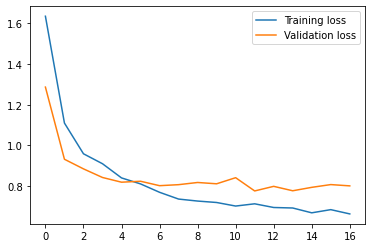

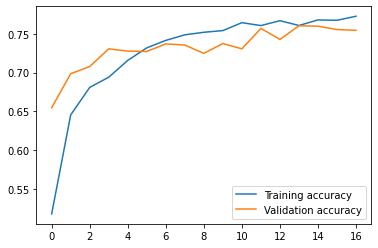

In [11]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001, amsgrad=0)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/100
257/257 [==============================] - 249s 896ms/step - loss: 1.3296 - accuracy: 0.6207 - val_loss: 1.8773 - val_accuracy: 0.4822
Epoch 2/100
257/257 [==============================] - 227s 883ms/step - loss: 0.6614 - accuracy: 0.7836 - val_loss: 0.5277 - val_accuracy: 0.8120
Epoch 3/100
257/257 [==============================] - 226s 879ms/step - loss: 0.5023 - accuracy: 0.8281 - val_loss: 0.4055 - val_accuracy: 0.8529
Epoch 4/100
257/257 [==============================] - 226s 879ms/step - loss: 0.4270 - accuracy: 0.8498 - val_loss: 0.3529 - val_accuracy: 0.8768
Epoch 5/100
257/257 [==============================] - 226s 878ms/step - loss: 0.3508 - accuracy: 0.8784 - val_loss: 0.3559 - val_accuracy: 0.8665
Epoch 6/100
257/257 [==============================] - 226s 878ms/step - loss: 0.3175 - accuracy: 0.8899 - val_loss: 0.3800 - val_accuracy: 0.8631
Epoch 7/100
257/257 [==============================] - 226s 879ms/step - loss: 0.2614 - accuracy: 0.9087 - val_loss: 0

2022/03/19 21:02:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


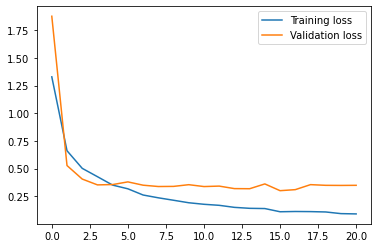

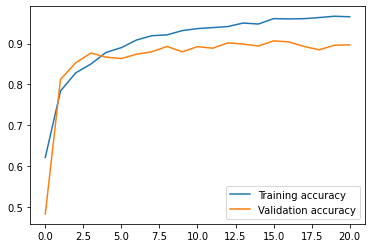

In [12]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
  for layer in model.layers[-23:]:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = True

  opt = Adam(learning_rate=1e-4)
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
              metrics=['accuracy'])
  
unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [13]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [14]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet.csv', index=False)
files.download('EfficientNetB2_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

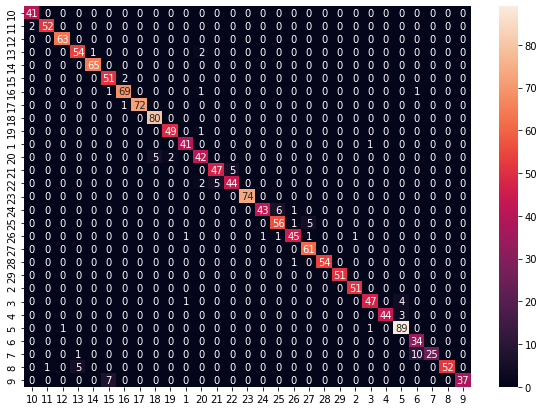

In [17]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

indexes = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)]

matrix = confusion_matrix(clases, list(classes),labels=indexes)

df_cm = pd.DataFrame(matrix, index = indexes, columns = indexes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)